100%|██████████| 9.91M/9.91M [00:02<00:00, 3.98MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.37MB/s]


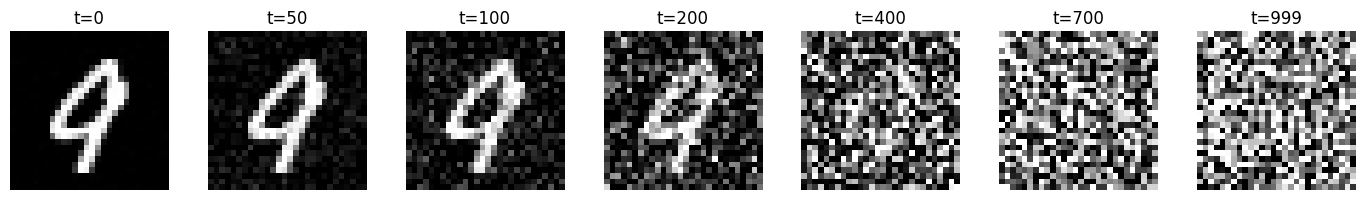

mean: 0.07178587466478348 std: 0.9970453381538391
alpha_bar[T-1] = 4.035829260828905e-05
noise mean: 0.0024036180693656206 noise std: 0.9974313378334045


  5%|▌         | 1/20 [00:53<16:56, 53.51s/it]

Epoch 0, Loss: 0.0661


 10%|█         | 2/20 [01:46<15:57, 53.17s/it]

Epoch 1, Loss: 0.0323


 15%|█▌        | 3/20 [02:38<14:55, 52.70s/it]

Epoch 2, Loss: 0.0293


 20%|██        | 4/20 [03:31<14:01, 52.60s/it]

Epoch 3, Loss: 0.0274


 25%|██▌       | 5/20 [04:23<13:07, 52.47s/it]

Epoch 4, Loss: 0.0267


 30%|███       | 6/20 [05:15<12:13, 52.36s/it]

Epoch 5, Loss: 0.0264


 35%|███▌      | 7/20 [06:07<11:20, 52.36s/it]

Epoch 6, Loss: 0.0259


 40%|████      | 8/20 [06:59<10:27, 52.31s/it]

Epoch 7, Loss: 0.0252


 45%|████▌     | 9/20 [07:52<09:35, 52.31s/it]

Epoch 8, Loss: 0.0251


 50%|█████     | 10/20 [08:44<08:43, 52.31s/it]

Epoch 9, Loss: 0.0249


 55%|█████▌    | 11/20 [09:36<07:50, 52.27s/it]

Epoch 10, Loss: 0.0248


 60%|██████    | 12/20 [10:28<06:57, 52.24s/it]

Epoch 11, Loss: 0.0247


 65%|██████▌   | 13/20 [11:21<06:05, 52.25s/it]

Epoch 12, Loss: 0.0246


 70%|███████   | 14/20 [12:13<05:13, 52.26s/it]

Epoch 13, Loss: 0.0243


 75%|███████▌  | 15/20 [13:05<04:21, 52.28s/it]

Epoch 14, Loss: 0.0245


 80%|████████  | 16/20 [13:58<03:29, 52.29s/it]

Epoch 15, Loss: 0.0241


 85%|████████▌ | 17/20 [14:50<02:36, 52.30s/it]

Epoch 16, Loss: 0.0238


 90%|█████████ | 18/20 [15:42<01:44, 52.32s/it]

Epoch 17, Loss: 0.0240


 95%|█████████▌| 19/20 [16:35<00:52, 52.30s/it]

Epoch 18, Loss: 0.0241


100%|██████████| 20/20 [17:27<00:00, 52.37s/it]

Epoch 19, Loss: 0.0241


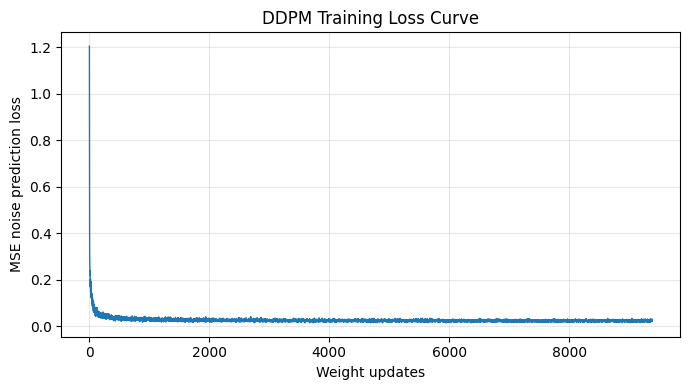

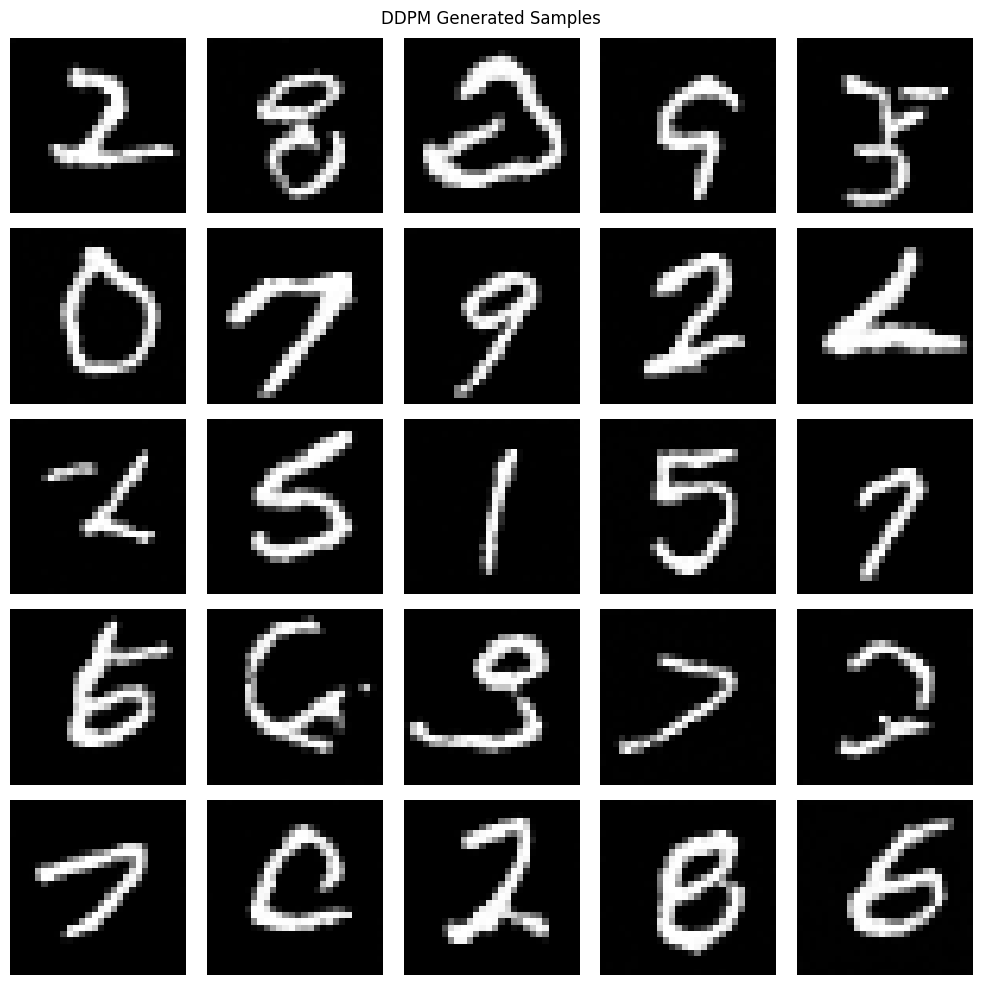

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import trange

tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*2.0-1.0)
])
train_ds = datasets.MNIST(root="./data", train=True, transform=tfm, download=True)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0, pin_memory=False) # Changed num_workers to 0 and pin_memory to False for debugging CUDA error

class DiffusionNoiseScheduler:
    def __init__(self, T=1000, beta_start=1e-4, beta_end=2e-2, device='cpu'):
        self.T =T
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, T, device=device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - self.alpha_bars)

    def sample_timesteps(self, batch_size):
        return torch.randint(0, self.T, (batch_size,), device=self.device)

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_ab = self.sqrt_alpha_bars[t].view(-1, 1, 1, 1)
        sqrt_1mab = self.sqrt_one_minus_alpha_bars[t].view(-1, 1, 1, 1)
        return sqrt_ab * x0 + sqrt_1mab * noise, noise

    @torch.no_grad()
    def show_noising_progress(sched, x0, timesteps=(0,50,100,200,400,700,999)):
        x0=x0.to(sched.device)
        imgs = []
        for t in timesteps:
            tt = torch.tensor([t], device=sched.device, dtype=torch.long)
            xt, _ = sched.q_sample(x0, tt)
            imgs.append(xt[0,0].detach().cpu())
        imgs = [(im+1)*0.5 for im in imgs]
        plt.figure(figsize=(len(timesteps)*2,2))
        for i, (t,im) in enumerate(zip(timesteps, imgs)):
            ax = plt.subplot(1, len(timesteps), i+1)
            ax.imshow(im, cmap='gray', vmin=0, vmax=1)
            ax.set_title(f't={t}')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scheduler = DiffusionNoiseScheduler(T=1000,device=device) # Corrected T from 200 to 1000
x0, _ = next(iter(train_loader))
x0 = x0.to(device)
t=scheduler.sample_timesteps(x0.size(0))
xt, eps = scheduler.q_sample(x0, t)
DiffusionNoiseScheduler.show_noising_progress(scheduler, x0[:1].to(device))
with torch.no_grad():
    t = torch.tensor([scheduler.T - 1], device=device)
    xt, _ = scheduler.q_sample(x0[0:1].to(device), t)
    print("mean:", xt.mean().item(), "std:", xt.std().item())
    print("alpha_bar[T-1] =", scheduler.alpha_bars[-1].item())
    noise = torch.randn_like(xt)
    print("noise mean:", noise.mean().item(), "noise std:", noise.std().item())


def sinusoidal_time_embedding(timesteps, dim, max_period=10000):
    half=dim//2
    freqs = torch.exp(-math.log(max_period) * torch.arange(0, half, device=timesteps.device).float()/half)
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0,1))
    return emb

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(t_dim, out_ch)
        self.norm1=nn.GroupNorm(8, out_ch)
        self.norm2=nn.GroupNorm(8, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.silu(h) # Corrected: Used F.silu as self.act was undefined
        t = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h+t
        h = self.conv2(h)
        h = self.norm2(h)
        h = F.silu(h) # Corrected: Used F.silu as self.act was undefined
        return h + self.skip(x)

class Downsample(nn.Module):
    def __init__(self, ch):
        super().__init__()
        # Corrected: Use Conv2d for downsampling
        self.conv = nn.Conv2d(ch, ch, 4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.tconv = nn.ConvTranspose2d(ch, ch, 4, stride=2, padding=1)

    def forward(self, x):
        return self.tconv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, t_dim=128):
        super().__init__()
        self.t_dim=t_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(t_dim, t_dim*4),
            nn.SiLU(),
            nn.Linear(t_dim*4, t_dim)
        )
        self.in_conv = nn.Conv2d(in_ch, base_ch, 3, padding=1)
        self.down1 = ResBlock(base_ch, base_ch, t_dim)
        self.ds1 = Downsample(base_ch)
        self.down2 = ResBlock(base_ch, base_ch*2, t_dim)
        self.ds2 = Downsample(base_ch*2)
        self.mid1 = ResBlock(base_ch*2, base_ch*2, t_dim)
        self.mid2 = ResBlock(base_ch*2, base_ch*2, t_dim)
        self.us2 = Upsample(base_ch*2)
        self.up2 = ResBlock(base_ch*4, base_ch*2, t_dim) # Corrected: in_ch for concat and out_ch for next stage
        self.us1 = Upsample(base_ch*2) # Corrected: input channels must match output of up2
        self.up1 = ResBlock(base_ch*3, base_ch, t_dim) # Corrected: in_ch for concat
        self.out_norm = nn.GroupNorm(8, base_ch)
        self.out_conv = nn.Conv2d(base_ch, 1, 3, padding=1)

    def forward(self, x, t):
        t_emb = sinusoidal_time_embedding(t, self.t_dim)
        t_emb = self.time_mlp(t_emb)
        x0 = self.in_conv(x)
        d1 = self.down1(x0, t_emb)
        x1 = self.ds1(d1)
        d2 = self.down2(x1, t_emb)
        x2 = self.ds2(d2)
        m = self.mid1(x2, t_emb)
        m = self.mid2(m, t_emb)
        u2 = self.us2(m)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.up2(u2, t_emb)
        u1 = self.us1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.up1(u1, t_emb)
        out = self.out_norm(u1)
        out = F.silu(out)
        eps_pred = self.out_conv(out)
        return eps_pred

    def train_ddpm_epoch(model, loader, sched, opt, device):
        model.train()
        total = 0.0
        n=0
        epoch_losses = []
        for x0, _ in loader:
            x0 = x0.to(device)
            B = x0.size(0)
            t = sched.sample_timesteps(B)
            xt, noise = sched.q_sample(x0, t)
            noise_pred = model(xt, t)
            loss = F.mse_loss(noise_pred, noise)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            total += loss.item()
            n+=1
            epoch_losses.append(loss.item())
        return total/max(n,1), epoch_losses

all_losses = []
steps = []
step = 0
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_ch=1, base_ch=64, t_dim=128).to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
for epoch in trange(epochs):
    loss, epoch_losses = UNet.train_ddpm_epoch(model, train_loader, scheduler, opt, device)
    for l in epoch_losses:
        step += 1
        all_losses.append(l)
        steps.append(step)
    print(f"Epoch {epoch}, Loss: {loss:.4f}")

plt.figure(figsize=(7,4))
plt.plot(steps, all_losses, linewidth=1)
plt.xlabel("Weight updates")
plt.ylabel("MSE noise prediction loss")
plt.title("DDPM Training Loss Curve")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

@torch.no_grad()
def ddpm_sample(model, sched, n =16, device=None):
    model.eval()
    device = device or sched.device
    x = torch.randn(n, 1, 28, 28, device=device)
    for t in reversed(range(sched.T)):
        tt = torch.full((n,), t, device = device, dtype=torch.long)
        eps_pred = model(x, tt)
        beta_t = sched.betas[t]
        alpha_t = sched.alphas[t]
        alpha_bar_t = sched.alpha_bars[t]
        coef1 = 1.0 / torch.sqrt(alpha_t)
        coef2 = (1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t)
        mean = coef1 * (x - coef2 * eps_pred)
        if t > 0:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(beta_t)
            x = mean + sigma_t * noise
        else:
            x = mean
    return x

def show_ddpm_samples(samples, title = "DDPM Samples"):
    # samples = (samples + 1) * 0.5
    samples = ((samples.clamp(-1,1) + 1) * 0.5).cpu().numpy()
    N= samples.shape[0]
    cols = int(np.ceil(np.sqrt(N)))
    rows = int(np.ceil(N / cols))
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(rows*cols):
        ax = plt.subplot(rows, cols, i+1)
        ax.axis("off")
        if i < N:
            ax.imshow(samples[i,0], cmap="gray", vmin=0, vmax=1)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

samples = ddpm_sample(model, scheduler, n=25, device=device)
show_ddpm_samples(samples, title="DDPM Generated Samples")

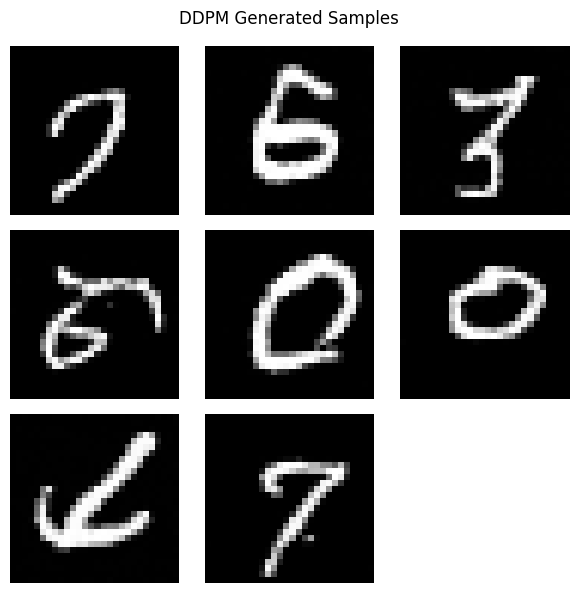

In [5]:
@torch.no_grad()
def ddpm_sample(model, sched, n=1, capture_ts=(999, 800, 600, 400, 200, 100, 0), device=None):
    model.eval()
    device = device or sched.device
    capture_set = set(capture_ts)
    snaps = {}
    x = torch.randn(n, 1, 28, 28, device=device)  # start from x_T ~ N(0,I)
    for t in reversed(range(sched.T)):
        tt = torch.full((n,), t, device=device, dtype=torch.long)
        eps_pred = model(x, tt)
        beta_t = sched.betas[t]
        alpha_t = sched.alphas[t]
        alpha_bar_t = sched.alpha_bars[t]
        # mean = 1/sqrt(alpha_t) * (x_t - (1-alpha_t)/sqrt(1-alpha_bar_t) * eps_pred)
        mean = (1.0 / torch.sqrt(alpha_t)) * (x - ((1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t)) * eps_pred)
        if t > 0:
            noise = torch.randn_like(x)
            x = mean + torch.sqrt(beta_t) * noise
        else:
            x = mean
        if t in capture_set:
            snaps[t] = x.detach().clone()
    return x, snaps


def show_ddpm_samples(samples, title = "DDPM Samples"):
    # samples = (samples + 1) * 0.5
    samples = ((samples.clamp(-1,1) + 1) * 0.5).cpu().numpy()
    N= samples.shape[0]
    cols = int(np.ceil(np.sqrt(N)))
    rows = int(np.ceil(N / cols))
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(rows*cols):
        ax = plt.subplot(rows, cols, i+1)
        ax.axis("off")
        if i < N:
            ax.imshow(samples[i,0], cmap="gray", vmin=0, vmax=1)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def _to_display(img_tensor):
    img = img_tensor.clamp(-1, 1)
    img = (img + 1) * 0.5
    return img.cpu()

def plot_denoising_steps(snaps, capture_ts):
    ts = list(capture_ts)
    ts_sorted = sorted(ts, reverse=True)
    plt.figure(figsize=(2*len(ts_sorted), 2))
    for i, t in enumerate(ts_sorted):
        ax = plt.subplot(1, len(ts_sorted), i+1)
        ax.axis("off")
        img = _to_display(snaps[t][0, 0])
        ax.imshow(img, cmap="gray", vmin=0, vmax=1)
        ax.set_title(f"t={t}")
    plt.tight_layout()
    plt.show()

def plot_denoising_grid(snaps, capture_ts, n_show=8):
    ts_sorted = sorted(capture_ts, reverse=True)
    rows = len(ts_sorted)
    cols = n_show
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    for r, t in enumerate(ts_sorted):
        x_t = snaps[t][:n_show]
        for c in range(n_show):
            ax = axes[r, c] if rows > 1 else axes[c]
            ax.axis("off")
            img = _to_display(x_t[c, 0])
            ax.imshow(img, cmap="gray", vmin=0, vmax=1)
            if c == 0:
                ax.set_title(f"t={t}")
    plt.tight_layout()
    plt.show()

capture_ts = (scheduler.T-1, 800, 600, 400, 200, 100, 0)
samples, snaps = ddpm_sample(model, scheduler, n=8, capture_ts=capture_ts, device=device) # Changed n from 1 to 8
show_ddpm_samples(samples, title="DDPM Generated Samples")

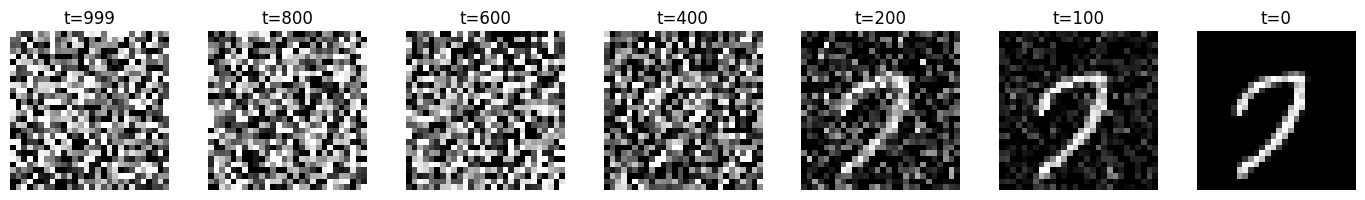

In [6]:
plot_denoising_steps(snaps, capture_ts)

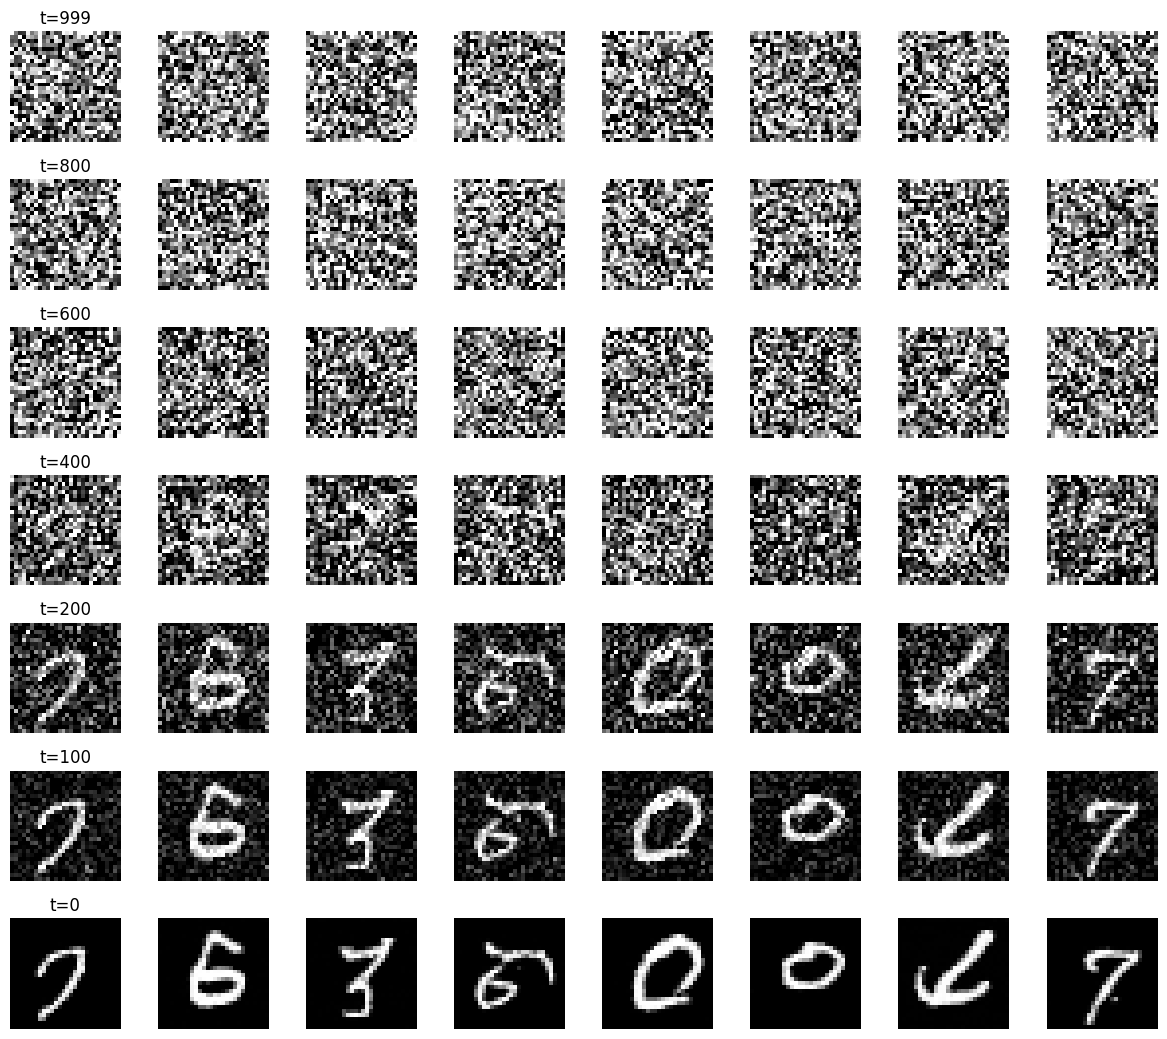

In [7]:
plot_denoising_grid(snaps, capture_ts, n_show=8)